<a href="https://colab.research.google.com/github/Nabbo-datsct/AMAZON-REVIEWS/blob/main/4_CLASSIFIER_DL2_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING LIBRARIES

In [ ]:
from google.colab import drive

import bz2        #for data extraction
import random

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()
nltk.download("stopwords") 
from nltk.corpus import stopwords
nltk.download('words')

import re
from bs4 import BeautifulSoup          #To remove html tags while preprocessing reviews.

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


# ESTABLISHING CONNECTION WITH GDRIVE

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# EXTRACTING DATA FROM GDRIVE

In [ ]:
train_file = bz2.BZ2File('/content/gdrive/My Drive/amazon reviews tar/train.ft.txt.bz2')
train_file_lines = train_file.readlines()
train_file_lines=random.sample(train_file_lines, 100000)
del train_file

# PRE-PROCESSING

 REMOVING STOPWORDS, NON-ENGLISH WORDS AND LEMMATIZING AND FILTERING WORDS WITH LENGTH LESS THAN 3.

In [ ]:
def remove_underscores(sentence):
    sentence= sentence.replace("_"," ")
    sentence = sentence.replace("\\","")
    return sentence

stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def remove_extra_words(sentence):     #remove stop words and meaningless words
    new_sentence=""
    for w in sentence.split():
        w=w.lower()
        if w in english_words and w not in stop_words and w.isalpha():
            new_sentence=new_sentence+" "+w
    return new_sentence

def lemmatize_and_filter(sentence, min_word_length):        #to lemmatize words and lose the ones with length less than equal to 3.
    sent = ""
    for word in sentence.split():
        word=word.lower()
        if len(lemmatizer.lemmatize(word))>3:
            sent= sent+" "+lemmatizer.lemmatize(word)
    return(sent)

### Postag screening
AN OPTIONAL PREPROCESSING

In [ ]:
import spacy

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def postags_screening(texts, allowed_postags=['ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc=nlp(sent)
        sent=""
        for token in doc:
            if token.lemma_ not in ['-PRON-'] and token.pos_ in allowed_postags:        
                sent=sent+" "+str(token.lemma_)
        texts_out.append(sent)
    return texts_out


In [ ]:
#re.sub(r'[^\w\s],"",string) to remove punctuations.
#re.sub(r'^https?:\/\/.*[\r\n]*', '', string) to remove urls.
#re.split("__label__[1|2]",string)[1] to get the 2nd element of the split, i.e, the review
#strip() to remove whitespaces
#re.findall("1|2", str(lines))[0] to store the first number encountered in the line of the review as the label of the review.
#BeautifulSoup(string, "lxml").text) to remove html tags


def split_label_review(data):
    #takes in list of raw data and returns list of string sentences and the list of their corresponding labels.
    labels = [int(re.findall("1|2", str(lines))[0]) for lines in data]
    reviews = [re.split("__label__[1|2]",str(lines))[1].strip().lower() for lines in data]
    return(reviews,labels)


def preprocessed_data(data):        #takes in list of raw data and returns list of processed string sentences and the list of their corresponding labels.
    reviews = [remove_extra_words(lemmatize_and_filter(BeautifulSoup(re.sub(r'[^\w\s]|^https?:\/\/.*[\r\n]*|\d+', '',
                                                                            remove_underscores(str(lines)).strip().lower()), "lxml").text,3)) for lines in data]
    reviews = postags_screening(reviews)
    return(reviews)

## TENSORFLOW (PREPROCESSING) : DATA TRANSFORMATION.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [ ]:
training_sentences, training_labels =  split_label_review(train_file_lines)
training_sentences = preprocessed_data(training_sentences)
del train_file_lines
tokenizer.fit_on_texts(training_sentences)
training_sequences = tokenizer.texts_to_sequences(training_sentences)
del training_sentences
training_padded = pad_sequences(training_sequences)
del training_sequences

In [ ]:
# Need this block to get it to work with TensorFlow 
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

In [ ]:
vocab_size = len(tokenizer.word_index)+1
print("Total number of tokens is ",vocab_size)

Total number of tokens is  5158


# **MODEL TRAINING**

## **MODEL4**

**NOTE:** TAKE FULL TRAINING DATA WITHOUT SPLITTING INTO TRAIN-VALIDATION 

In [ ]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 100))
model4.add(tf.keras.layers.Dropout(0.5))
model4.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model4.add(tf.keras.layers.Dense(1, activation='relu'))

model4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         515800    
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 596,301
Trainable params: 596,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [ tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.25, patience=2, cooldown=0)]

history4 = model4.fit(training_padded, training_labels, epochs=5,
                    batch_size=500,
                    validation_split=0.25,
                    verbose=1,callbacks=callbacks)        #no. of training samples = 1,00,000*0.75=75,000; 75,000/500= 150 batches 

Epoch 1/5
8/8 [==============================] - 11s 912ms/step - loss: 4.6145 - accuracy: 0.0048 - val_loss: 0.2200 - val_accuracy: 0.3424
Epoch 2/5
8/8 [==============================] - 6s 761ms/step - loss: -5.9249 - accuracy: 0.4928 - val_loss: -7.8076 - val_accuracy: 0.4880
Epoch 3/5
8/8 [==============================] - 6s 769ms/step - loss: -7.3847 - accuracy: 0.5157 - val_loss: -7.8076 - val_accuracy: 0.4880
Epoch 4/5
8/8 [==============================] - 6s 765ms/step - loss: -7.3847 - accuracy: 0.5157 - val_loss: -7.8076 - val_accuracy: 0.4880
Epoch 5/5
8/8 [==============================] - 6s 769ms/step - loss: -7.3847 - accuracy: 0.5157 - val_loss: -7.8076 - val_accuracy: 0.4880


## **MODEL5**

In [ ]:
embed_dim = 128
lstm_out = 196

model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Embedding(vocab_size, embed_dim,input_length = training_padded.shape[1]))
model5.add(tf.keras.layers.SpatialDropout1D(0.4))
model5.add(tf.keras.layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model5.add(tf.keras.layers.Dense(1,activation='relu'))
model5.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model5.summary())

CB=[ tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.25, patience=2, cooldown=0)]
history5 = model5.fit(training_padded, training_labels, epochs=5, validation_split=0.25, verbose=1,callbacks=CB)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 128)           660224    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 52, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 197       
Total params: 915,221
Trainable params: 915,221
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
118/118 [==============================] - 40s 313ms/step - loss: -6.7597 - accuracy: 0.4923 - val_loss: -7.8076 - val_accuracy: 0.4880
Epoch 2/5
118/118 [==============================] - 37s 311ms/step - loss: -7.3847 - accuracy:

## EVALUATION

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  


In [ ]:
history4.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

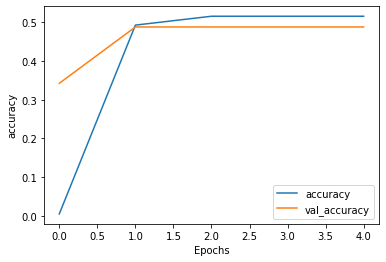

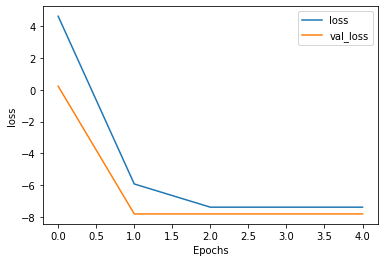

In [ ]:
plot_graphs(history4, "accuracy")
plot_graphs(history4, "loss")


In [ ]:
history5.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

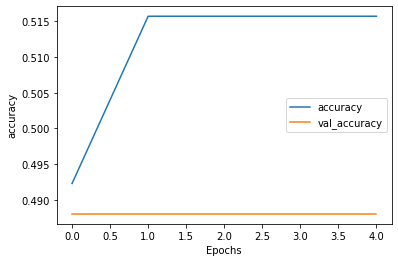

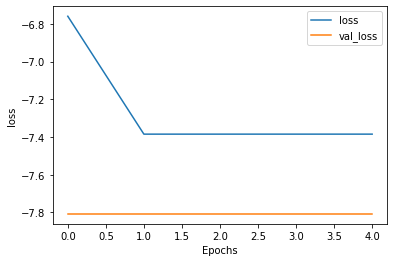

In [ ]:
plot_graphs(history5, "accuracy")
plot_graphs(history5, "loss")
